In [83]:
import pandas as pd
import matplotlib.pyplot as plt


In [84]:
df = pd.read_csv('srpski.csv', sep='\t')
df = df.drop(columns=['Rbr', 'SR', 'sr/sr', 'Naslov', 'Jezik'])
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].str.lower()

Dodavanje duplikata

In [85]:
author_counts = df['Autor'].value_counts()
single_instance_authors = author_counts[author_counts == 1].index

unique_authors_rows = df[df['Autor'].isin(single_instance_authors)].copy()
df = pd.concat([df, unique_authors_rows], ignore_index=True)
df['Autor'] = df['Autor'].astype('category').cat.codes


Tokenizacija reci i recenica


In [86]:
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jelenalazovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [87]:
class LangVars(PunktLanguageVars):
    sent_end_chars = ('.', '!', '?', ';', ":", "...", '..','…')
custom_sent_tokenizer = PunktSentenceTokenizer(lang_vars=LangVars())
df['Recenice'] = df['Tekst'].apply(custom_sent_tokenizer.tokenize)

In [88]:
custom_tokenizer = RegexpTokenizer(r'\w+[\'\’]*\w*|[^\w\s]')
df['Tokeni'] = df['Tekst'].apply(custom_tokenizer.tokenize)

In [89]:
punctuation = r'[^\w\s]'
def remove_punctuation(tokens): 
    filtered_tokens = [word for word in tokens if not re.match(punctuation, word)]
    return filtered_tokens

df['Filtrirani tokeni'] = df['Tokeni'].apply(remove_punctuation)

In [90]:
from nltk import FreqDist

In [91]:
all_words = [word for words in df['Filtrirani tokeni'] for word in words]
fdist = FreqDist(all_words)
stopwords = [word for word, count in fdist.items() if count > 50 or (len(word) in (1,2,3) and count > 20)]

In [92]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return filtered_tokens

df['Filtrirani tokeni'] = df['Filtrirani tokeni'].apply(remove_stopwords)

Podela podataka na trening i test

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X = df[['Recenice', 'Tokeni','Filtrirani tokeni']]
y = df['Autor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Stilometrijske analize

In [95]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


In [96]:
def average_word_length(words):
    return sum(len(word) for word in words) / len(words)

df_train['Duzina reci'] = df_train['Filtrirani tokeni'].apply(average_word_length)
df_test['Duzina reci'] = df_test['Filtrirani tokeni'].apply(average_word_length)


In [97]:
df_avgWordLength = df_train.groupby('Autor')['Duzina reci'].mean().reset_index()

In [98]:
import matplotlib.pyplot as plt


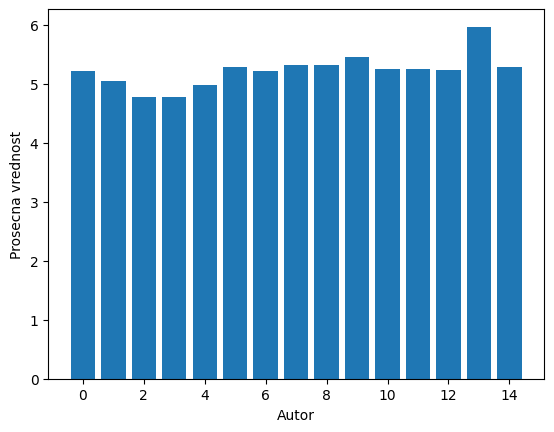

In [109]:
plt.bar(df_avgWordLength['Autor'], df_avgWordLength['Duzina reci'])
plt.xlabel('Autor')
plt.ylabel('Prosecna vrednost')
plt.show()

In [100]:
def average_sentence_length(sentences):
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

df_train['Duzina recenica'] = df_train['Recenice'].apply(average_sentence_length)
df_test['Duzina recenica'] = df_test['Recenice'].apply(average_sentence_length)


In [101]:
df_avgSentLength = df_train.groupby('Autor')['Duzina recenica'].mean().reset_index()


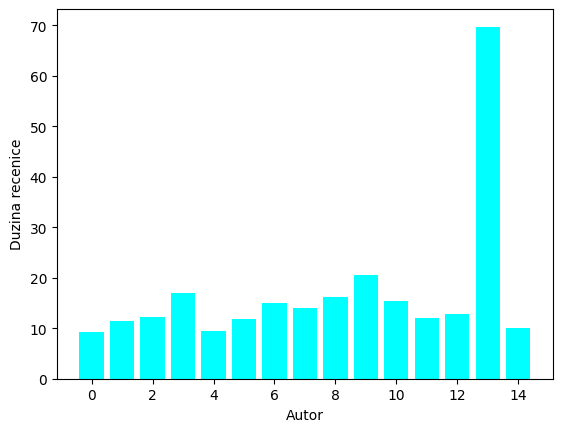

In [102]:
plt.bar(df_avgSentLength['Autor'], df_avgSentLength['Duzina recenica'], color='cyan')
plt.xlabel('Autor')
plt.ylabel('Duzina recenice')
plt.show()

In [103]:
def text_length(words):
    return sum(len(word) for word in words)
df_train['Duzina teksta'] = df_train['Tokeni'].apply(text_length)
df_test['Duzina teksta'] = df_test['Tokeni'].apply(text_length)

In [104]:
df_avgTextLength = df_train.groupby('Autor')['Duzina teksta'].mean().reset_index()


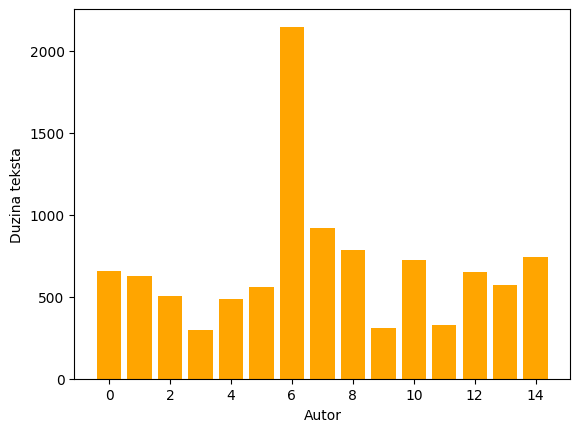

In [105]:
plt.bar(df_avgTextLength['Autor'], df_avgTextLength['Duzina teksta'], color='orange')
plt.xlabel('Autor')
plt.ylabel('Duzina teksta')
plt.show()

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier(max_depth=5,min_samples_split=15, n_estimators=300)
model.fit(df_train[['Duzina recenica', 'Duzina teksta']],df_train['Autor'])
y_pred = model.predict(df_test[['Duzina recenica', 'Duzina teksta']])
report = accuracy_score(df_test['Autor'], y_pred)
report

0.17647058823529413

In [107]:

y_pred1 = model.predict(df_train[['Duzina recenica', 'Duzina teksta']])
report1 = accuracy_score(df_train['Autor'], y_pred1)
report1


0.6582278481012658